# Introduction
How to open and understand the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor 
from sklearn.ensemble import HistGradientBoostingRegressor 

## Basic information
1. Hyperspectral data:
    1. `hsi_path` contains path to hyperspectral masked numpy arrays containing hyperspectral data that underwent masking (i.e., the field area is masked, whereas all irrelevant areas are not masked)
    2. The name of the file (e.g., _'1989.npz'_) refers to the index of the corresponding training sample in the ground-truth table.
2. Ground-truth data:
    1. `gt_path` contains path to ground truth .csv file.
    2. Additionally, `wavelength_path` contains the mapping between a band number and the corresponding wavelength.


In [2]:
hsi_path = '../train_data/train_data/train_data/1570.npz'
gt_path = '../train_data/train_data/train_gt.csv'
wavelength_path = '../train_data/train_data/wavelengths.csv'

In [3]:
gt_df = pd.read_csv(gt_path)
wavelength_df = pd.read_csv(wavelength_path)

In [4]:
gt_df.head()

,sample_index,P,K,Mg,pH
0,0,45.1,188.0,179.0,7.2
1,1,44.8,205.0,188.0,7.0
2,2,44.4,207.0,145.0,6.8
3,3,46.5,204.0,143.0,6.8
4,4,52.0,212.0,167.0,6.7


In [5]:
wavelength_df

,band_no,wavelength
0,1,462.08
1,2,465.27
2,3,468.47
3,4,471.67
4,5,474.86
...,...,...
145,146,925.58
146,147,928.78
147,148,931.98
148,149,935.17


In [6]:
wavelength_df['wavelength'].diff(1).mean()

3.196577181208054

## Ground-truth description
`gt_df` contains:

1. `sample_index` - a reference to the numpay array containing the corresponding hyperspectral data.
2. P (for simplicity, we use P while referring to P_2O_5), K, Mg, pH - soil properties levels based on laboratory measurements.

In [7]:
gt_df[gt_df['sample_index']==1570]

,sample_index,P,K,Mg,pH
1570,1570,47.9,165.0,181.0,6.8


## Displaying one hyperspectral band

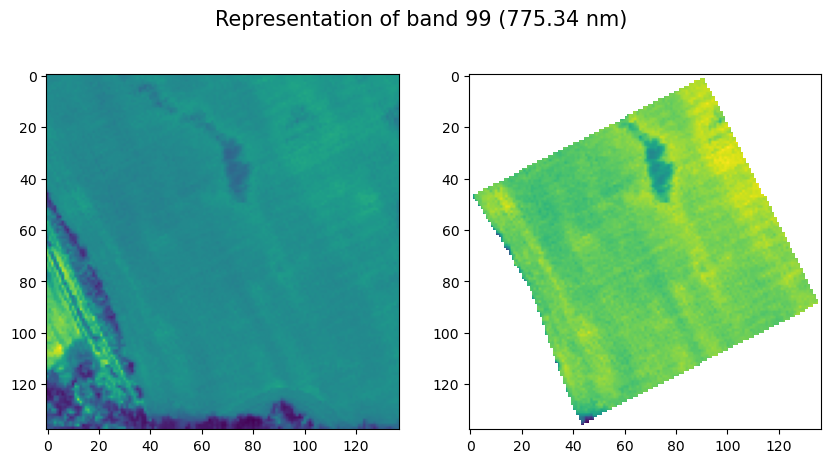

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 99
wavelength = wavelength_df.loc[band_id-1]

with np.load(hsi_path) as npz:
    arr = np.ma.MaskedArray(**npz)

axs[0].imshow(arr[band_id,:,:].data)
axs[1].imshow(arr[band_id,:,:])
plt.suptitle(f'Representation of band {int(wavelength["band_no"])} ({wavelength["wavelength"]} nm)', fontsize=15)
plt.show()

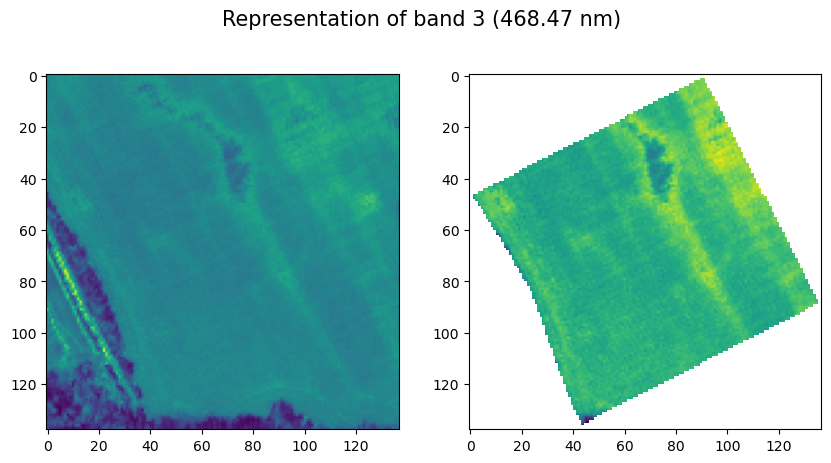

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 3
wavelength = wavelength_df.loc[band_id-1]

with np.load(hsi_path) as npz:
    arr = np.ma.MaskedArray(**npz)

axs[0].imshow(arr[band_id,:,:].data)
axs[1].imshow(arr[band_id,:,:])
plt.suptitle(f'Representation of band {int(wavelength["band_no"])} ({wavelength["wavelength"]} nm)', fontsize=15)
plt.show()

## Displaying the aggregated spectral curve for a field

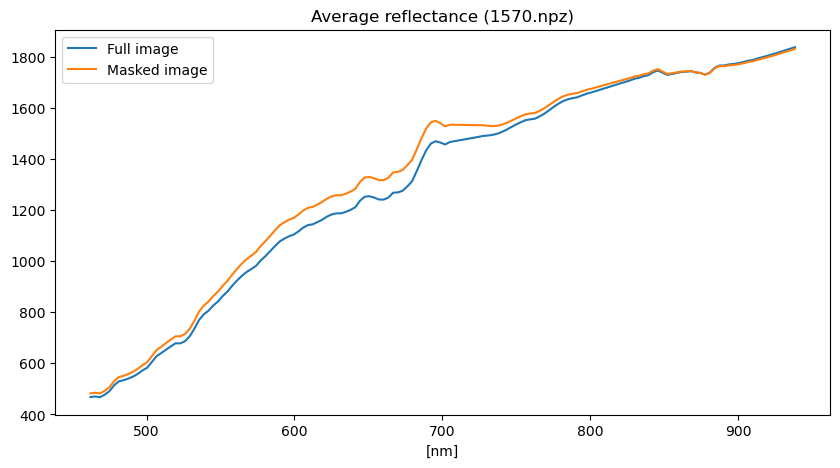

In [10]:
fig = plt.figure(figsize=(10, 5))

masked_scene_mean_spectral_reflectance = [arr[i,:,:].mean() for i in range(arr.shape[0])]
full_scene_mean_spectral_reflectance = [arr[i,:,:].data.mean() for i in range(arr.shape[0])]

plt.plot(wavelength_df['wavelength'], full_scene_mean_spectral_reflectance, label='Full image')
plt.plot(wavelength_df['wavelength'], masked_scene_mean_spectral_reflectance, label='Masked image')

plt.xlabel('[nm]')
plt.legend()
plt.title(f'Average reflectance ({hsi_path.split("/")[-1]})')
plt.show()

# Generating baseline solution

In [11]:
class BaselineRegressor:
    """
    Baseline regressor, which calculates the mean value of the target from the training
    data and returns it for each testing sample.
    """
    def __init__(self):
        self.mean = 0

    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        self.mean = np.mean(y_train, axis=0)
        self.classes_count = y_train.shape[1]
        return self

    def predict(self, X_test: np.ndarray):
        return np.full((len(X_test), self.classes_count), self.mean)


class SpectralCurveFiltering():
    """
    Create a histogram (a spectral curve) of a 3D cube, using the merge_function
    to aggregate all pixels within one band. The return array will have
    the shape of [CHANNELS_COUNT]
    """

    def __init__(self, merge_function = np.mean):
        self.merge_function = merge_function

    def __call__(self, sample: np.ndarray):
        return self.merge_function(sample, axis=(1, 2))


## Load the data

In [12]:
import os
from glob import glob

def load_data(directory: str):
    """Load each cube, reduce its dimensionality and append to array.

    Args:
        directory (str): Directory to either train or test set
    Returns:
        [type]: A list with spectral curve for each sample.
    """
    data = []
    filtering = SpectralCurveFiltering()
    all_files = np.array(
        sorted(
            glob(os.path.join(directory, "*.npz")),
            key=lambda x: int(os.path.basename(x).replace(".npz", "")),
        )
    )
    for file_name in all_files:
        with np.load(file_name) as npz:
            arr = np.ma.MaskedArray(**npz)
        arr = filtering(arr)
        data.append(arr)
    return np.array(data)


def load_gt(file_path: str):
    """Load labels for train set from the ground truth file.
    Args:
        file_path (str): Path to the ground truth .csv file.
    Returns:
        [type]: 2D numpy array with soil properties levels
    """
    gt_file = pd.read_csv(file_path)
    labels = gt_file[["P", "K", "Mg", "pH"]].values
    return labels


X_train = load_data("../train_data/train_data/train_data/")
y_train = load_gt("../train_data/train_data/train_gt.csv")
X_test = load_data("../test_data/test_data/")

print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


Train data shape: (1732, 150)
Test data shape: (1154, 150)


In [13]:
def averaging(data,step_size):
    # Initialize a list to store the means
    means = []
    num_columns = data.shape[1]
    # Loop through the columns in groups of 3
    for i in range(0, num_columns, step_size):
        subset = data[:, i:i+step_size]  # Get the subset of columns
        column_means = np.mean(subset, axis=1)  # Calculate the mean for each row in the subset
        means.append(column_means)

    # Stack the means into a single NumPy array
    result = np.column_stack(means)
    
    return result



In [14]:
average_two_train = averaging(X_train,2)
average_two_test = averaging(X_test,2)
average_three_train = averaging(X_train,3)
average_three_test = averaging(X_test,3)
average_five_train = averaging(X_train,5)
average_five_test = averaging(X_test,5)
average_seven_train = averaging(X_train,7)
average_seven_test = averaging(X_test,7)
average_ten_train = averaging(X_train,10)
average_ten_test = averaging(X_test,10)

X_train = np.hstack((X_train,average_two_train,average_five_train,average_ten_train))

X_test = np.hstack((X_test,average_two_test,average_five_test,average_ten_test))

In [15]:
y_train

array([[ 45.1, 188. , 179. ,   7.2],
       [ 44.8, 205. , 188. ,   7. ],
       [ 44.4, 207. , 145. ,   6.8],
       ...,
       [ 39.4, 180. , 122. ,   6.5],
       [ 37.3, 162. , 127. ,   6.5],
       [ 29.5, 146. , 133. ,   6.3]])

In [16]:
y_train_k = y_train[:,1]

In [17]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

In [19]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Make predictions and generate submission file

In [20]:
def training(X,y,reg,num,test_data,pca_transform = False):
    test_data_new = test_data
    # Define the number of folds
    n_splits = 10  # You can adjust this as needed

    # Initialize the KFold cross-validator
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initialize arrays to store metrics for each fold
    rmse = []
    val_fold_predictions= []
    test_fold_predictions = []

    # Loop over the folds

    for train_index, val_index in kf.split(X, y):
        # Split the data into training and validation sets for this fold
        X_train, y_train = X[train_index], y[train_index]
        X_val, y_val = X[val_index], y[val_index]
        
        if pca_transform == True:
            pca = PCA(n_components = num,random_state = 1)
            X_train = pca.fit_transform(X_train)
            X_val = pca.transform(X_val)
            test_data_new = pca.transform(test_data)      

        reg.fit(X_train, y_train)

        # Predict on the validation set for this fold
        fold_predictions = reg.predict(X_val)
        fold_predictions = fold_predictions/y_train_k.mean()
        test_predictions = reg.predict(test_data_new)
        test_predictions = test_predictions/y_train_k.mean()
        y_val = y_val/y_train_k.mean()

        val_fold_predictions.append(fold_predictions)
        test_fold_predictions.append(test_predictions)


        # Calculate metrics for this fold and store them
        rmse.append(np.sqrt(mean_squared_error(y_val, fold_predictions)))


    predictions = np.mean(np.array(test_fold_predictions ), axis=0)

    # Calculate the mean of each metric across all folds
    mean_rmse = np.mean(rmse)
    print(f'The mean rmse is {mean_rmse}')

    return predictions

In [21]:
# reg = LGBMRegressor(n_estimators = 20, random_state = 42)
# lgbm_without_pca_20_estimators = training(X_train,y_train_k,reg,0,X_test,pca_transform = False)

In [22]:
# reg = LGBMRegressor(n_estimators = 50, random_state = 42)
# lgbm_without_pca_50_estimators = training(X_train,y_train_k,reg,0,X_test,pca_transform = False)

In [23]:
# reg = LGBMRegressor(n_estimators = 100, random_state = 42)
# lgbm_without_pca_100_estimators = training(X_train,y_train_k,reg,0,X_test,pca_transform = False)

In [24]:
# reg = LGBMRegressor(n_estimators = 150, random_state = 42)
# lgbm_without_pca_150_estimators = training(X_train,y_train_k,reg,0,X_test,pca_transform = False)

In [25]:
# X_train

In [26]:
reg = LGBMRegressor(n_estimators = 20, random_state = 42)
lgbm_with_130_pca_20_estimators = training(X_train,y_train_k,reg,130,X_test,pca_transform = True)

The mean rmse is 0.25314400194086023


In [27]:
reg = LGBMRegressor(n_estimators = 50, random_state = 42)
lgbm_with_130_pca_50_estimators = training(X_train,y_train_k,reg,130,X_test,pca_transform = True)

The mean rmse is 0.24959058498089778


In [28]:
reg = LGBMRegressor(n_estimators = 100, random_state = 42)
lgbm_with_130_pca_100_estimators = training(X_train,y_train_k,reg,130,X_test,pca_transform = True)

The mean rmse is 0.2484631927644431


In [29]:
reg = LGBMRegressor(n_estimators = 20, random_state = 42)
lgbm_with_100_pca_20_estimators = training(X_train,y_train_k,reg,100,X_test,pca_transform = True)

The mean rmse is 0.25219406385812226


In [30]:
reg = LGBMRegressor(n_estimators = 50, random_state = 42)
lgbm_with_100_pca_50_estimators = training(X_train,y_train_k,reg,100,X_test,pca_transform = True)

The mean rmse is 0.24915141136385435


In [31]:
reg = LGBMRegressor(n_estimators = 100, random_state = 42)
lgbm_with_100_pca_100_estimators = training(X_train,y_train_k,reg,100,X_test,pca_transform = True)

The mean rmse is 0.24843837784664435


In [32]:
reg = LGBMRegressor(n_estimators = 20, random_state = 42)
lgbm_with_80_pca_20_estimators = training(X_train,y_train_k,reg,80,X_test,pca_transform = True)

The mean rmse is 0.25056325133260887


In [33]:
reg = LGBMRegressor(n_estimators = 50, random_state = 42)
lgbm_with_80_pca_50_estimators = training(X_train,y_train_k,reg,80,X_test,pca_transform = True)

The mean rmse is 0.24795900621467873


In [34]:
reg = LGBMRegressor(n_estimators = 100, random_state = 42)
lgbm_with_80_pca_100_estimators = training(X_train,y_train_k,reg,80,X_test,pca_transform = True)

The mean rmse is 0.24758620502061918


In [44]:
predictions = np.mean((
#     (lgbm_without_pca_20_estimators,lgbm_without_pca_50_estimators,lgbm_without_pca_100_estimators,
#          lgbm_without_pca_150_estimators,
#     lgbm_with_130_pca_20_estimators,
         lgbm_with_130_pca_50_estimators,lgbm_with_130_pca_100_estimators,
#         lgbm_with_100_pca_20_estimators,
    lgbm_with_100_pca_50_estimators,
         lgbm_with_100_pca_100_estimators,
#     lgbm_with_80_pca_20_estimators,
        lgbm_with_80_pca_50_estimators,lgbm_with_80_pca_100_estimators),axis = 0)

In [45]:
len(predictions)

1154

In [46]:
# baseline_reg = BaselineRegressor()
# baseline_reg = baseline_reg.fit(X_train, y_train)
# mean_val = np.mean(y_train,axis=0)
# predictions = baseline_reg.predict(X_test)
# predictions = predictions/mean_val


# predictions = lgbm.predict(X_test)
# predictions = predictions/mean_val


submission = pd.DataFrame(data = predictions, columns=["K"])
submission.to_csv("submission.csv", index_label="sample_index")


In [47]:
# baseline_reg.predict(X_train)

In [48]:
submission

,K
0,0.987388
1,0.978412
2,1.053459
3,1.066930
4,1.006197
...,...
1149,0.794336
1150,0.895415
1151,1.080169
1152,0.902105


In [49]:
new_index = [str(i) + '_K' for i in submission.index ]
sub = pd.DataFrame(submission['K'].values, index = new_index)
sub.to_csv( "sub_K.csv", index_label = "sample_index" )

In [50]:
sub

,0
0_K,0.987388
1_K,0.978412
2_K,1.053459
3_K,1.066930
4_K,1.006197
...,...
1149_K,0.794336
1150_K,0.895415
1151_K,1.080169
1152_K,0.902105


In [51]:
# tall_sub = []
# # for i in [ "P", "K", "Mg", "pH" ] :
# tall_sub.append(pd.DataFrame(submission.values, index = submission.index.to_series().apply( lambda x : str ( x ) + "_P" +  ) ) )
# tall_sub = pd.concat( tall_sub, axis = 0 )
# tall_sub.to_csv( "sub.csv", index_label = "sample_index" )

## Calculating the metric

For the purpose of presenting the final metric calculation, we will extract a small _test_set_ from the training set.

In [52]:
# X_test = X_train[1500:]
# y_test = y_train[1500:]

# X_train_new = X_train[:1500]
# y_train_new = y_train[:1500]

# # Fit the baseline regressor once again on new training set
# baseline_reg = baseline_reg.fit(X_train_new, y_train_new)
# baseline_predictions = baseline_reg.predict(X_test)

# # Generate baseline values to be used in score computation
# baselines = np.mean((y_test - baseline_predictions) ** 2, axis=0)


# # Generate random predictions, different from baseline predictions
# np.random.seed(9)
# predictions = np.zeros_like(y_test)
# for column_index in range(predictions.shape[1]):
#     class_mean_value = baseline_reg.mean[column_index]
#     predictions[:, column_index] = np.random.uniform(low=class_mean_value - class_mean_value * 0.05,
#                                                      high=class_mean_value + class_mean_value * 0.05,
#                                                      size=len(predictions))

# # Calculate MSE for each class
# mse = np.mean((y_test - predictions) ** 2, axis=0)

# # Calculate the score for each class individually
# scores = mse / baselines

# # Calculate the final score
# final_score = np.mean(scores)

# for score, class_name in zip(scores, ["P", "K", "Mg", "pH"]):
#     print(f"Class {class_name} score: {score}")

# print(f"Final score: {final_score}")